In [1]:
from util import *
%matplotlib inline
from IPython.display import Image
from IPython.core.display import HTML 

/Users/edithzeng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


1/31/2019

Below are my findings about questions in VizWiz & VQA datasets based on the training sets from Nilavra. 
Assumptions - 
- VizWiz consists of primarily questions from blind users, whereas VQA's questions come from visually-abled crowd workers (Agrawal et al. 2015, p4); 
- skills labelled are indicative of users' information needs; and 
- human opinions are limited, expensive and more reliable whereas automated solutions are cheaper but less accurate, and there's a trade-off when we try to combine the two.

0) Where did the skills categories come from (not from VQA?)

1) Skills -- class distributions:
- Both datasets are heavily focused on object recognition task (98% in VizWiz and 99% in VQA)
- Differences between VizWiz and VQA's class distributions suggest:
 - blind users had significantly higher demands for text recognition (VQA training set is much smaller though)
 - blind users appear less interested in counting tasks. Perhaps it's because they can count the number of coin or the number of shirts by touching the objects?
 
2) Although both datasets consist of primarily object recognition questions, questions are expressed in different ways. We can further look into this to highlight the unique needs of blind users.
- VizWiz: most questions are variants of the question "what is this?" A trivial classifier can confidently predict "object recognition" based on the first couple words and, as I've mentioned in the course project report, in most cases the skill can be predicted without the corresponding image.
- VQA: most questions gives away what object is in the picture. eg. question "are these trains moving?" is labelled as object recognition, but the relevant object (trains) is already mentioned in the question. It's a priori for the respondent to be able to identify the object so that they can answer the question. 

3) Knowing the skills can help when we don't have the ability to fully automate object recognition task with a high level of granularity. For example, as opposed to generating the label "bottle," the description "a white bottle of 36 oz Dove shampoo" contains text recognition, color recognition and counting while performing object recognition, and a blind user could find it useful to know such granular information about the scene that would be available to a visually-abled person (i.e. seeing the shampoo bottle with all the texts and colors, as opposed to just parts that are relevant to the question). The fact that crowd workers labelled almost all of VizWiz and VQA tasks as object recognition suggests that most of these pairs are inherently context-based recognition tasks.

4) Therefore, these predetermined skill categories are important when we come to consider improving the status quo. It also suggests that down the road we need some form of user research with qualitative components to better understand blind users' needs.

5) If we're interested in developing assitive tools with a focus on visually impaired users, VizWiz will be more appropriate than VQA (which is smaller and contains more descriptive questions). 

Some ideas for improving the status quo for object recognition subcategory: 
 - Estimate/quantify the difficulty of object recognition task. Automate tasks with high confidence level and route the difficult/uncertain ones to humans. This could be done by automatically analyzing the quality of question (ie how clearly does the user express their information needs) and photo (ie if the image contains sufficient relevant information for a human to answer the question). One example is to include an automated quality check to extract keyword in the question, and check if image contains such object, before sending it out for community answering. 
 - Train on domain-specific data set to improve object recognition. Compared to VQA, most objects in VizWiz questions focus on domestic objects.
 
Ideas for text recognition tasks (30% of VizWiz):
 - Automatically detect text recognition taks based on the question and route the task to ML algorithms (reduce human efforts)
 - For the task above, detect if texts in the image are recognizable/answerable. 

Color recognition tasks (37% of VizWiz and 35% of VQA):
 - Many color recognition questions contains the word "color" in its question. We can perhaps focus on the image part and add a step of auto-correction or otherwise determine image quality when trying to label the task?
 
Analysis of task/user:
 - Understand the correlations between the skills (eg. under what circumstances does an object recognition task require color recognition? Can we use one as a proxy to improve performance?)
 - Qualitative user study on their information need
 - Determine what type of questions likely require more skills as opposed to just one (eg. poorly lit image for object recognition may require color/text recognition--examples at the end of this file).


High frequency words (log n scale, removing stop words)
- VizWiz: daily objects & identification questions 
- VQA: more diverse contents; more descriptive nouns and verbs

VizWiz
![VizWiz](./vizwiz_wordcloud.svg)
## [VizWiz Word Cloud](https://github.com/edithzeng/VQA_skills/blob/master/vizwiz_wordcloud.svg)

VQA
![VQA](./vqa_wordcloud.svg)
## [VQA Word Cloud](https://github.com/edithzeng/VQA_skills/blob/master/vqa_wordcloud.svg)

Images
- VizWiz: inconsistent image quality
- VQA: labelled image with MSCOCO captions

Text + Image
- For most entries in both datasets, skills are dependent on questions (text) only. Images are often irrelevant in determining the skills required.

In [3]:
# traning sets only
vizwiz = pd.read_csv('../dataset_skill_typ/vizwiz_skill_typ_train.csv', skipinitialspace=True, engine='python')
vqa = pd.read_csv('../dataset_skill_typ/vqa_skill_typ_train.csv', skipinitialspace=True, engine='python')
targets = np.array(['TXT', 'OBJ', 'COL', 'CNT', 'OTH'])

In [4]:
len(vizwiz)

14269

In [5]:
len(vqa)

3230

#### check class distributions
def skills_class_distribution(df):
    class_dist = []
    for skill in targets:
        percent = len(df.loc[df[skill]==1])/len(df)
        temp = {'skill':skill, '%':percent}
        class_dist.append(temp)
    return pd.DataFrame(class_dist)

In [4]:
vizwiz_skill_dist = skills_class_distribution(vizwiz)

In [5]:
vizwiz_skill_dist

,%,skill
0,0.561847,TXT
1,0.984652,OBJ
2,0.379564,COL
3,0.036513,CNT
4,0.001542,OTH


In [6]:
vqa_skill_dist = skills_class_distribution(vqa)

In [7]:
vqa_skill_dist

,%,skill
0,0.110836,TXT
1,0.995975,OBJ
2,0.355418,COL
3,0.204644,CNT
4,0.018576,OTH


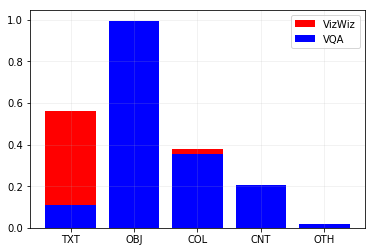

In [8]:
fig, ax = plt.subplots()
rects1 = ax.bar(targets, vizwiz_skill_dist['%'].values, color='r', label='VizWiz')
rects2 = ax.bar(targets, vqa_skill_dist['%'].values, color='b', label='VQA')
plt.grid(alpha=.2)
plt.legend()

plt.show()  # note the difference in text recognition

In [110]:
# check correlations between certain keywords and a question being labelled for a certain skillset

df = vizwiz.copy()
df['obj_keyword'] = 0
df['color_keyword'] = 0
df['text_keyword'] = 0
df['count_keyword'] = 0

for i, row in df.iterrows():
    question = row[2].lower()
    if "what is this" in question:
        df.iloc[i,19] = 1
    if "color" in question:
        df.iloc[i,20] = 1
    if "say" in question:
        df.iloc[i,21] = 1
    if "many" in question or "much" in question:
        df.iloc[i,22] = 1

In [111]:
df[['TXT', 'OBJ', 'COL', 'CNT', 'OTH', 'obj_keyword', 'color_keyword', 'text_keyword','count_keyword']].corr()

,TXT,OBJ,COL,CNT,OTH,obj_keyword,color_keyword,text_keyword,count_keyword
TXT,1.000000,0.031074,-0.479960,0.094344,-0.019298,0.006768,-0.432996,0.150167,0.019031
OBJ,0.031074,1.000000,-0.035096,0.006068,0.004906,0.060392,-0.127140,-0.001179,0.009684
COL,-0.479960,-0.035096,1.000000,-0.106065,-0.016013,-0.130548,0.524348,-0.072632,-0.037827
CNT,0.094344,0.006068,-0.106065,1.000000,-0.007650,-0.082836,-0.071459,0.020494,0.297442
OTH,-0.019298,0.004906,-0.016013,-0.007650,1.000000,-0.019836,-0.016141,-0.008403,0.026325
obj_keyword,0.006768,0.060392,-0.130548,-0.082836,-0.019836,1.000000,-0.239541,-0.123675,-0.061531
color_keyword,-0.432996,-0.127140,0.524348,-0.071459,-0.016141,-0.239541,1.000000,-0.069315,-0.030836
text_keyword,0.150167,-0.001179,-0.072632,0.020494,-0.008403,-0.123675,-0.069315,1.000000,-0.013173
count_keyword,0.019031,0.009684,-0.037827,0.297442,0.026325,-0.061531,-0.030836,-0.013173,1.000000


In [114]:
# correlations between categories:
# word "color" in question and color recognition skill
# word "color" in question and text recogintion skill

# due to class imbalance (98% true), the Pearson correlation coef
# between "what is this" and "object recognition" flag is very small

# For questions that are labelled as "color recognition" besides "object recognition"
# but does not contain the word "color" in the question,
# many are due to poor photos. eg. "What is this spice?" with strange lighting.
# Therefore, working on determine the image quality could be another way.
df.loc[df['COL'] == 1, 'QSN'].head(50)

7                                             This item.
8                              What color do these look?
10                                              Is this.
11                                         what is this?
12                           What kind of drink is this?
13               What color... what color is this skirt?
17     Can I ask about anything or any information wi...
18                                    What is this game?
19                                  What is in this can?
22                            What is this a picture of?
26     What color furniture is that?  And is that nic...
30                              What is on the bar code?
32                                   What is this spice?
40     Please describe the pattern and color of this ...
44                          What type of chips are this?
54                               Is my - is my light on?
56                                 What am I looking at?
57                             

2/7/19

In [36]:
# strong correlation between "TXT" and "COL" in the subgroup NOT labelled for 'OBJ'
vizwiz.loc[vizwiz['OBJ']==0].corr()

,TXT,OBJ,COL,CNT,OTH
TXT,1.000000,NaN,-0.893742,0.189978,NaN
OBJ,NaN,NaN,NaN,NaN,NaN
COL,-0.893742,NaN,1.000000,-0.173289,NaN
CNT,0.189978,NaN,-0.173289,1.000000,NaN
OTH,NaN,NaN,NaN,NaN,NaN


In [64]:
vizwiz.loc[vizwiz['OBJ'] == 0][['QID', 'QSN', 'COL', 'TXT', 'OTH']]

,QID,QSN,COL,TXT,OTH
117,VizWiz_train_000000000177.jpg,What soap is this?,0,1,0
171,VizWiz_train_000000000262.jpg,What color is this?,1,0,0
330,VizWiz_train_000000000505.jpg,How clear is this text?,0,1,0
336,VizWiz_train_000000000514.jpg,What color is this shirt?,1,0,0
443,VizWiz_train_000000000669.jpg,What color is this shirt?,1,0,0
480,VizWiz_train_000000000719.jpg,What's the color?,1,0,0
663,VizWiz_train_000000000980.jpg,Is this a plain white t-shirt?,1,0,0
684,VizWiz_train_000000001013.jpg,"Can you tell me what this food item is, please...",0,1,0
750,VizWiz_train_000000001101.jpg,what color is this shirt?,1,0,0
751,VizWiz_train_000000001102.jpg,Color is this?,1,0,0


In [38]:
# correlation between COL and TXT in VQA, but not as strong as in VizWiz
# stronger correlation between CNT & TXT but based on a very small subset (see below)
vqa.loc[vqa['OBJ']==0].corr()

,QID,TXT,OBJ,COL,CNT,OTH
QID,1.000000,-0.135583,NaN,-0.294048,-0.508976,NaN
TXT,-0.135583,1.000000,NaN,-0.365148,0.426006,NaN
OBJ,NaN,NaN,NaN,NaN,NaN,NaN
COL,-0.294048,-0.365148,NaN,1.000000,0.133333,NaN
CNT,-0.508976,0.426006,NaN,0.133333,1.000000,NaN
OTH,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# VizWiz: check how many tasks have more than one skills
0 in vizwiz[['TXT', 'OBJ', 'COL', 'CNT', 'OTH']]

False

In [22]:
# question length
(vizwiz['QSN'].str.split().apply(len).value_counts()) / len(vizwiz)

3     0.233373
4     0.191955
5     0.154110
6     0.120751
7     0.067279
8     0.042189
9     0.032798
10    0.026071
2     0.021725
11    0.017591
12    0.015488
14    0.010232
13    0.009882
15    0.007359
16    0.007148
17    0.005326
18    0.005116
19    0.003855
21    0.003224
20    0.003224
22    0.002383
24    0.002383
23    0.002243
25    0.001962
26    0.001892
27    0.001332
31    0.001051
30    0.000981
28    0.000911
29    0.000771
32    0.000631
36    0.000631
33    0.000631
35    0.000561
40    0.000350
41    0.000350
39    0.000350
34    0.000350
44    0.000280
43    0.000280
42    0.000140
45    0.000140
53    0.000140
38    0.000140
46    0.000140
49    0.000070
50    0.000070
37    0.000070
48    0.000070
Name: QSN, dtype: float64

In [30]:
# average sentence length for VizWiz
np.mean(vizwiz['QSN'].str.split().apply(len))

6.245917723736772

In [25]:
(vqa['QSN'].str.split().apply(len).value_counts())/len(vqa)

5     0.253870
6     0.201548
7     0.167802
4     0.122910
8     0.099381
9     0.055108
10    0.035294
3     0.020124
11    0.016409
12    0.011765
13    0.004644
14    0.004334
15    0.002477
16    0.002477
17    0.001238
20    0.000619
Name: QSN, dtype: float64

In [31]:
# average sentence length for VQA
np.mean(vqa['QSN'].str.split().apply(len))

6.402167182662539